In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
df_results = pd.read_csv(os.path.join(os.getcwd(), 'e_from_nms_conf.csv'))
df_results

,path,face_index,nms,conf,e_bbox_yn,e_bbox_mp,e_bbox_yf
0,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.1,0.220,0.225,0.205
1,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.3,0.185,0.225,0.190
2,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.5,0.165,0.225,0.185
3,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.7,0.150,0.225,0.175
4,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.9,0.135,0.225,0.165
...,...,...,...,...,...,...,...
845,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,4,0.9,0.1,3.100,0.000,0.415
846,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,4,0.9,0.3,0.360,0.000,0.225
847,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,4,0.9,0.5,0.240,0.000,0.045
848,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,4,0.9,0.7,0.060,0.000,0.020


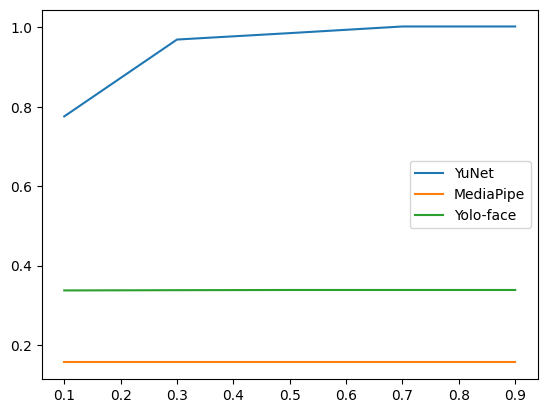

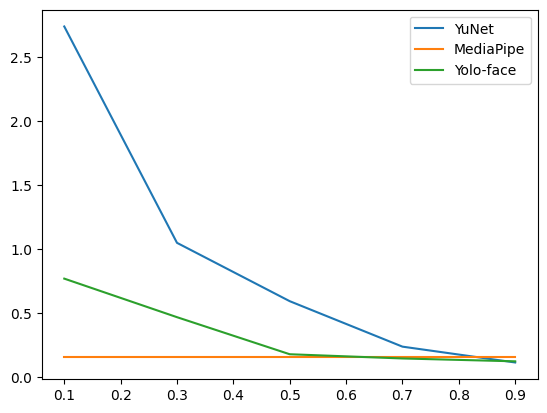

In [3]:
nms_group = df_results.groupby("nms")
plt.plot(nms_group.groups.keys(), nms_group.mean(numeric_only = True).iloc[:, -3:], label=["YuNet", "MediaPipe", "Yolo-face"])
plt.legend()
plt.show()

conf_group = df_results.groupby("conf")
plt.plot(conf_group.groups.keys(), conf_group.mean(numeric_only = True).iloc[:, -3:], label=["YuNet", "MediaPipe", "Yolo-face"])
plt.legend()
plt.show()

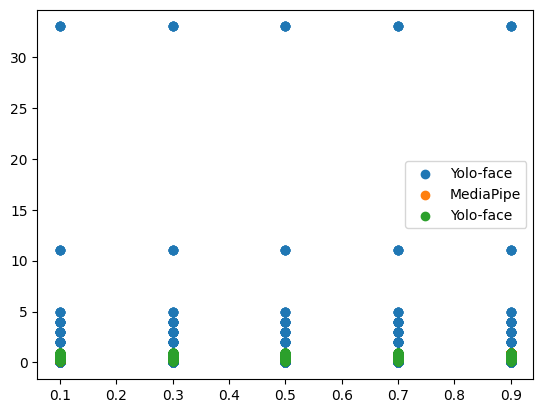

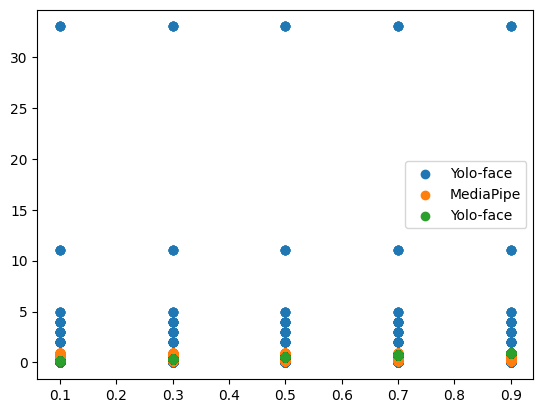

In [4]:
plt.scatter(df_results["nms"], df_results.iloc[:, -6], label="Yolo-face")
plt.scatter(df_results["nms"], df_results.iloc[:, -5], label="MediaPipe")
plt.scatter(df_results["nms"], df_results.iloc[:, -4], label="Yolo-face")
plt.legend()
plt.show()

plt.scatter(df_results["conf"], df_results.iloc[:, -6], label="Yolo-face")
plt.scatter(df_results["conf"], df_results.iloc[:, -5], label="MediaPipe")
plt.scatter(df_results["conf"], df_results.iloc[:, -4], label="Yolo-face")
plt.legend()
plt.show()

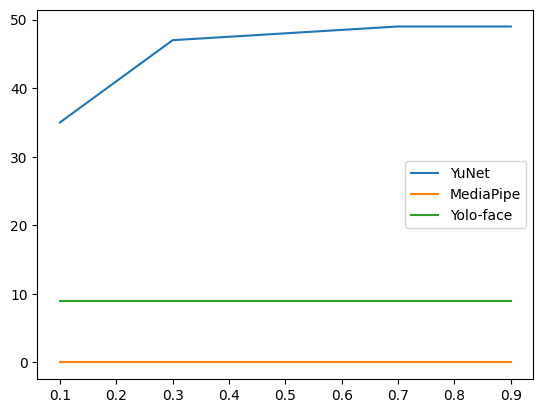

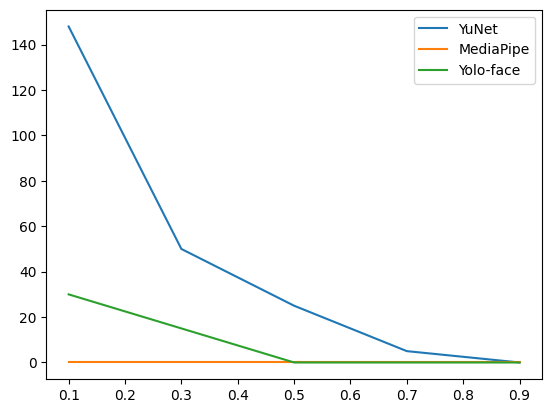

In [5]:
plt.plot(nms_group.groups.keys(), nms_group.apply((lambda x: (x.iloc[:, -3:] >= 3).sum())), label=["YuNet", "MediaPipe", "Yolo-face"])
plt.legend()
plt.show()

plt.plot(conf_group.groups.keys(), conf_group.apply((lambda x: (x.iloc[:, -3:] >= 3).sum())), label=["YuNet", "MediaPipe", "Yolo-face"])
plt.legend()
plt.show()

___

In [6]:
import minepsilon as minE

import itertools
import random
import os

import cv2
import torch
from torch import autograd
import torchvision.transforms as transforms

from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression
from pytorchyolo.utils.loss import compute_loss

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


face_detection_yunet_2022mar.onnx:: status : file already exists


In [7]:
REF_SET = pd.read_csv(os.path.join(os.getcwd(), 'reference_dataset.csv'), index_col=0)
REF_SET.reset_index()
REF_SET = REF_SET[REF_SET["path"].str.contains("amosc")]              #<-- only sample fr ur local files (smth only u hv in path)
celeba_rows = REF_SET["path"].str.contains("celeba")
REF_SET_celeba = REF_SET[celeba_rows].sample(16)                      #<-- Change face sample count for celeba
REF_SET_wider = REF_SET[celeba_rows == False].sample(16)              #<-- Change face sample count for widerface
sample_set = pd.concat([REF_SET_celeba, REF_SET_wider])

In [8]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device, model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")

CUDA Available:  False


In [9]:
def detach_cpu(image):
    return image.detach().cpu()

# convert 1x3x416x416 to 416x416x3
def reshape_image(image):
    return np.transpose(np.squeeze(image), (1 ,2, 0))

# convert 1x3x416x416 tensor to 416x416x3 numpy image
def tensor_to_image(image):
    return np.transpose(image.detach().cpu().squeeze().numpy(), (1, 2, 0))

def save_tensor_as_image(image, path):
    save_img = cv2.cvtColor(np.moveaxis((image.detach().numpy() * 255).squeeze(), 0, -1).astype('uint8'), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, save_img)

In [10]:
nms_scores = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_scores = [0.1, 0.3, 0.5, 0.7, 0.9]
df = pd.DataFrame()
row = {}

for path in sample_set["path"]:
    torch.autograd.set_detect_anomaly(True)
    row['path'] = path
    REF_SUBSET = sample_set[sample_set['path'] == path]

    model.eval()
    model.gradient_mode = False
    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = False

    # read and transform the image from the path
    data = cv2.imread(path)  # read the image
    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
    data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image

    with torch.no_grad():
        # Forward pass the data through the model and call non max suppression
        nms, nms_output = non_max_suppression(model(data), 0.5, 0.5) #conf_thres and iou_thres = 0.5

    face_list = []
    if type(nms_output[0]) is not int:
        face_list = nms_output[0]

    data = data.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    model.gradient_mode = True
    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = True

    output = model(data)

    # loop through each of the faces in the image
    for face_index, face_row in enumerate(face_list):
        row['face_index'] = face_index

        if face_index in set(REF_SUBSET['face_index']):
            x, y, w, h = face_row[0], face_row[1], face_row[2], face_row[3]

            factor_x, factor_y, factor_w, factor_h = random.uniform(1, 2), random.uniform(1, 2), random.uniform(1, 2), random.uniform(1, 2)
            normal_x, normal_y, normal_w, normal_h = x / 416, y / 416, w / 416, h / 416

            new_x = normal_x * factor_x if random.choice([True, False]) else normal_x / factor_x
            new_y = normal_y * factor_y if random.choice([True, False]) else normal_y / factor_y
            new_w = normal_w * factor_w if random.choice([True, False]) else normal_w / factor_w
            new_h = normal_h * factor_h if random.choice([True, False]) else normal_h / factor_h

            new_x, new_y, new_w, new_h = max(min(1, new_x), 0), max(min(1, new_y), 0), max(min(1, new_w), 0), max(min(1, new_h), 0)

            target = torch.tensor([[0.0, 0, new_x, new_y, new_w, new_h]])
            target = target.to(device)

            loss, loss_components = compute_loss(output, target, model)

            # cropped image with bounding box
            # getting (x1, y1) upper left, (x2, y2) lower right
            x1 = max(int(np.floor((x - w / 2).detach().cpu().numpy())), 0)
            y1 = max(int(np.floor((y - h / 2).detach().cpu().numpy())), 0)
            x2 = min(int(np.ceil((x + w / 2).detach().cpu().numpy())), 415)
            y2 = min(int(np.ceil((y + h / 2).detach().cpu().numpy())), 415)

            cropped_image = detach_cpu(data)[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
            cropped_image = tensor_to_image(cropped_image) #reshape the image to (w/h, h/w, channel)

            # Zero all existing gradients
            model.zero_grad()
            data.grad = None

            # Calculate gradients of model in backward pass
            loss.backward(retain_graph=True)

            # Collect datagrad
            data_grad = data.grad.data

            bbox = (x1, y1, x2, y2)

            bbox_mask = np.zeros(data.shape)
            bbox_mask[..., y1:y2, x1:x2] = 1
            for nms, conf in itertools.product(nms_scores, conf_scores):
                row["nms"] = nms
                row["conf"] = conf
                minE.nms_thres = nms
                minE.conf_thres = conf

                yn_min_e_bbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yn_det_fn, bbox_mask, bbox)
                mp_min_e_bbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.mp_det_fn, bbox_mask, bbox)
                yf_min_e_bbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yf_det_fn, bbox_mask, bbox)

                print("yn min bbox:", yn_min_e_bbox, "mp min bbox:", mp_min_e_bbox, "yf min bbox:", yf_min_e_bbox)
                row['e_bbox_yn'], row['e_bbox_mp'], row['e_bbox_yf'] = yn_min_e_bbox, mp_min_e_bbox, yf_min_e_bbox

                df = df.append(row, ignore_index=True)
df.to_csv('e_from_nms_conf.csv', index=False)

yn min bbox: 0.21999999999999997 mp min bbox: 0.22499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.22499999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.22499999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.22499999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.22499999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.22499999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.47000000000000014


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.315 mp min bbox: 0.305 yf min bbox: 0.305


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0.305 yf min bbox: 0.285


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.305 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.47000000000000014


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.315 mp min bbox: 0.305 yf min bbox: 0.305


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0.305 yf min bbox: 0.285


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.305 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.47000000000000014


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.315 mp min bbox: 0.305 yf min bbox: 0.305


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0.305 yf min bbox: 0.285


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.305 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.47000000000000014


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.315 mp min bbox: 0.305 yf min bbox: 0.305


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0.305 yf min bbox: 0.285


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.305 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.47000000000000014


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.305 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.315 mp min bbox: 0.305 yf min bbox: 0.305


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0.305 yf min bbox: 0.285


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.305 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.25499999999999995 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.35000000000000003 mp min bbox: 0.25499999999999995 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.35000000000000003 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.295 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.25499999999999995 yf min bbox: 0.11499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.25499999999999995 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.35000000000000003 mp min bbox: 0.25499999999999995 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.35000000000000003 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.295 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.25499999999999995 yf min bbox: 0.11499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.25499999999999995 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.35000000000000003 mp min bbox: 0.25499999999999995 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.35000000000000003 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.295 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.25499999999999995 yf min bbox: 0.11499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.25499999999999995 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.25499999999999995 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.4450000000000001 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.295 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.25499999999999995 yf min bbox: 0.11499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.25499999999999995 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.25499999999999995 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.4450000000000001 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.295 mp min bbox: 0.25499999999999995 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.25499999999999995 yf min bbox: 0.11499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19499999999999998 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19499999999999998 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19499999999999998 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19499999999999998 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19499999999999998 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19499999999999998 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19499999999999998 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.18499999999999997 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.20999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0.18499999999999997 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.18499999999999997 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.20999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0.18499999999999997 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.18499999999999997 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.20999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0.18499999999999997 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.18499999999999997 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.20999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0.18499999999999997 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.18499999999999997 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.20999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.18499999999999997 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0.18499999999999997 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.5550000000000002


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.4550000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.7900000000000004 mp min bbox: 0.27999999999999997 yf min bbox: 0.4000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.4050000000000001 mp min bbox: 0.27999999999999997 yf min bbox: 0.325


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.5550000000000002


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.4550000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.7900000000000004 mp min bbox: 0.27999999999999997 yf min bbox: 0.4000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.4050000000000001 mp min bbox: 0.27999999999999997 yf min bbox: 0.325


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.5550000000000002


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.4550000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.7900000000000004 mp min bbox: 0.27999999999999997 yf min bbox: 0.4000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.4050000000000001 mp min bbox: 0.27999999999999997 yf min bbox: 0.325


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.5550000000000002


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.4550000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.7900000000000004 mp min bbox: 0.27999999999999997 yf min bbox: 0.4000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.4050000000000001 mp min bbox: 0.27999999999999997 yf min bbox: 0.325


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.5550000000000002


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.27999999999999997 yf min bbox: 0.4550000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.7900000000000004 mp min bbox: 0.27999999999999997 yf min bbox: 0.4000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.4050000000000001 mp min bbox: 0.27999999999999997 yf min bbox: 0.325


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.34500000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0.26499999999999996 yf min bbox: 0.295


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0.26499999999999996 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.26499999999999996 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.34500000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0.26499999999999996 yf min bbox: 0.295


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0.26499999999999996 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.26499999999999996 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.34500000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0.26499999999999996 yf min bbox: 0.295


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0.26499999999999996 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.26499999999999996 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.34500000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0.26499999999999996 yf min bbox: 0.295


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0.26499999999999996 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.26499999999999996 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.34500000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26499999999999996 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0.26499999999999996 yf min bbox: 0.295


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0.26499999999999996 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.26499999999999996 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.3 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.3 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.3 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.3 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.3 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.3 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.22499999999999998 yf min bbox: 0.015


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.175 mp min bbox: 0.22499999999999998 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.22499999999999998 yf min bbox: 0.015


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.175 mp min bbox: 0.22499999999999998 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.22499999999999998 yf min bbox: 0.015


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.175 mp min bbox: 0.22499999999999998 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.22499999999999998 yf min bbox: 0.015


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.17999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.175 mp min bbox: 0.22499999999999998 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.22499999999999998 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0.22499999999999998 yf min bbox: 0.015


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.4350000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.22999999999999995 mp min bbox: 0.295 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.295 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.4350000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.22999999999999995 mp min bbox: 0.295 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.295 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.4350000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.22999999999999995 mp min bbox: 0.295 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.295 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.4350000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.22999999999999995 mp min bbox: 0.295 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.295 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.4350000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.295 yf min bbox: 0.27499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.22999999999999995 mp min bbox: 0.295 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.295 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.20499999999999996 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.20499999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.20499999999999996 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.20499999999999996 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.20499999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.20499999999999996 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.20499999999999996 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.20499999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.20499999999999996 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.20499999999999996 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.20499999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.20499999999999996 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.20499999999999996 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20499999999999996 yf min bbox: 0.21499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.20499999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.20499999999999996 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20999999999999996 mp min bbox: 0.16999999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16999999999999998 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.16999999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.15


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.34 mp min bbox: 0.16999999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16999999999999998 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.16999999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.15


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.34 mp min bbox: 0.16999999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16999999999999998 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.16999999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.15


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.34 mp min bbox: 0.16999999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16999999999999998 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.16999999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.15


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.34 mp min bbox: 0.16999999999999998 yf min bbox: 0.18999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16999999999999998 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.16999999999999998 yf min bbox: 0.16499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.15


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0.16999999999999998 yf min bbox: 0.12999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.26499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.26999999999999996 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.26999999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.26499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.26999999999999996 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.26999999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.26499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.26999999999999996 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.26999999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.26499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.26999999999999996 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.26999999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.26499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.26999999999999996 yf min bbox: 0.23999999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.26999999999999996 yf min bbox: 0.21999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.26999999999999996 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.34 mp min bbox: 0.6700000000000003 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.34 mp min bbox: 0.6700000000000003 yf min bbox: 0.4450000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.6700000000000003 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.27999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.6700000000000003 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.35000000000000003 mp min bbox: 0.6700000000000003 yf min bbox: 0.4450000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.6700000000000003 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.27999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.6700000000000003 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.6700000000000003 yf min bbox: 0.4450000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.6700000000000003 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.27999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.6700000000000003 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.6700000000000003 yf min bbox: 0.4450000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.6700000000000003 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.27999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.6700000000000003 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.6700000000000003 yf min bbox: 0.4450000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.19999999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.38000000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.6700000000000003 yf min bbox: 0.33


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.6700000000000003 yf min bbox: 0.27999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.38000000000000006 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.38000000000000006 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.38000000000000006 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.38000000000000006 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.38000000000000006 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.38000000000000006 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.38000000000000006 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.38000000000000006 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.38000000000000006 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.38000000000000006 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.38000000000000006 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.38000000000000006 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19999999999999998 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.23499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19999999999999998 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19999999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19999999999999998 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.23499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19999999999999998 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19999999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19999999999999998 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.23499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19999999999999998 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19999999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19999999999999998 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.23499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19999999999999998 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19999999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.19999999999999998 yf min bbox: 0.31


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.23499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0.19999999999999998 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.19999999999999998 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.19999999999999998 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.04000000000000001 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.04000000000000001 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.04000000000000001 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.04000000000000001 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.04000000000000001 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.4250000000000001 mp min bbox: 0.095 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.095 yf min bbox: 0.060000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.095 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.095 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.095 yf min bbox: 0.060000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.095 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.095 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.095 yf min bbox: 0.060000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.095 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.095 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.095 yf min bbox: 0.060000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.095 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.095 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.095 yf min bbox: 0.060000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.125 mp min bbox: 0.095 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.095 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.6750000000000003 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.03500000000000001 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.03500000000000001 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.03500000000000001 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.03500000000000001 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.25999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.05500000000000001 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.03500000000000001 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.10999999999999999 mp min bbox: 0 yf min bbox: 0.065


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.6850000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36500000000000005 mp min bbox: 0 yf min bbox: 0.38500000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.009999999999999998 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.6850000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36500000000000005 mp min bbox: 0 yf min bbox: 0.38500000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.009999999999999998 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.6850000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36500000000000005 mp min bbox: 0 yf min bbox: 0.38500000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.009999999999999998 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.6850000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36500000000000005 mp min bbox: 0 yf min bbox: 0.38500000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.009999999999999998 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.6850000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36500000000000005 mp min bbox: 0 yf min bbox: 0.38500000000000006


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.22999999999999995


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.045000000000000005 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.009999999999999998 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.29 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.26999999999999996 mp min bbox: 0 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21999999999999997 mp min bbox: 0 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.26999999999999996 mp min bbox: 0 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21999999999999997 mp min bbox: 0 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.26999999999999996 mp min bbox: 0 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21999999999999997 mp min bbox: 0 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.26999999999999996 mp min bbox: 0 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21999999999999997 mp min bbox: 0 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.26999999999999996 mp min bbox: 0 yf min bbox: 0.20499999999999996


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21999999999999997 mp min bbox: 0 yf min bbox: 0.19499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.04000000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.03500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.25499999999999995 mp min bbox: 0 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.25499999999999995 mp min bbox: 0 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.25499999999999995 mp min bbox: 0 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.25499999999999995 mp min bbox: 0 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.1


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.25499999999999995 mp min bbox: 0 yf min bbox: 0.07


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0.35000000000000003


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.16499999999999998 yf min bbox: 0.4100000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.27999999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16499999999999998 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.16499999999999998 yf min bbox: 0.4100000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.27999999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16499999999999998 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.16499999999999998 yf min bbox: 0.4100000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.27999999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16499999999999998 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.16499999999999998 yf min bbox: 0.4100000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.27999999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16499999999999998 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.16499999999999998 yf min bbox: 0.4100000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.27999999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.125


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.21499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18499999999999997 mp min bbox: 0.16499999999999998 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.16499999999999998 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.7650000000000003 mp min bbox: 0 yf min bbox: 0.4250000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.36500000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15499999999999997 mp min bbox: 0 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.4250000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.36500000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15499999999999997 mp min bbox: 0 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.4250000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.36500000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15499999999999997 mp min bbox: 0 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.4250000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.36500000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15499999999999997 mp min bbox: 0 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.4250000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0 yf min bbox: 0.36500000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0 yf min bbox: 0.335


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15499999999999997 mp min bbox: 0 yf min bbox: 0.3


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13999999999999999 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.3950000000000001 mp min bbox: 0 yf min bbox: 0.16999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.13499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07999999999999999 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.13499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07999999999999999 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.13499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07999999999999999 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.13499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07999999999999999 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.19999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0 yf min bbox: 0.13499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07999999999999999 mp min bbox: 0 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.5450000000000002 mp min bbox: 0.22499999999999998 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.22499999999999998 yf min bbox: 0.08499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0.22499999999999998 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0.22499999999999998 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.22499999999999998 yf min bbox: 0.08499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0.22499999999999998 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0.22499999999999998 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.22499999999999998 yf min bbox: 0.08499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0.22499999999999998 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0.22499999999999998 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.22499999999999998 yf min bbox: 0.08499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0.22499999999999998 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0.22499999999999998 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.22499999999999998 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16999999999999998 mp min bbox: 0.22499999999999998 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12 mp min bbox: 0.22499999999999998 yf min bbox: 0.08499999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.1 mp min bbox: 0.22499999999999998 yf min bbox: 0.07999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0.22499999999999998 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.20499999999999996 mp min bbox: 0.20999999999999996 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0.20999999999999996 yf min bbox: 0.24999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.20999999999999996 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.20999999999999996 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0.20999999999999996 yf min bbox: 0.24999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.20999999999999996 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.20999999999999996 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0.20999999999999996 yf min bbox: 0.24999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.20999999999999996 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.20999999999999996 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0.20999999999999996 yf min bbox: 0.24999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.20999999999999996 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.20999999999999996 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.17999999999999997 mp min bbox: 0.20999999999999996 yf min bbox: 0.24999999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15 mp min bbox: 0.20999999999999996 yf min bbox: 0.175


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.12999999999999998 mp min bbox: 0.20999999999999996 yf min bbox: 0.15999999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.24499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.18999999999999997 mp min bbox: 0 yf min bbox: 0.18499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.15999999999999998 mp min bbox: 0 yf min bbox: 0.13999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.13499999999999998 mp min bbox: 0 yf min bbox: 0.10999999999999999


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.09 mp min bbox: 0 yf min bbox: 0.09


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.175 yf min bbox: 0.4500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.175 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.175 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.175 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0.175 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.175 yf min bbox: 0.4500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.175 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.175 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.175 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0.175 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.175 yf min bbox: 0.4500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.175 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.175 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.175 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0.175 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.175 yf min bbox: 0.4500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.175 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.175 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.175 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0.175 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0.175 yf min bbox: 0.4500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.16499999999999998 mp min bbox: 0.175 yf min bbox: 0.12


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0.175 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0.175 yf min bbox: 0.095


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.07500000000000001 mp min bbox: 0.175 yf min bbox: 0.07500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 3.0999999999999974


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.145 mp min bbox: 0 yf min bbox: 0.15499999999999997


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.11499999999999999 mp min bbox: 0 yf min bbox: 0.10499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.095 mp min bbox: 0 yf min bbox: 0.05500000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.4150000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36000000000000004 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.060000000000000005 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.4150000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36000000000000004 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.060000000000000005 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.4150000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36000000000000004 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.060000000000000005 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.4150000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36000000000000004 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.060000000000000005 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 3.0999999999999974 mp min bbox: 0 yf min bbox: 0.4150000000000001


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.36000000000000004 mp min bbox: 0 yf min bbox: 0.22499999999999998


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.23999999999999996 mp min bbox: 0 yf min bbox: 0.045000000000000005


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.060000000000000005 mp min bbox: 0 yf min bbox: 0.02


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


yn min bbox: 0.02 mp min bbox: 0 yf min bbox: 0


C:\Users\amosc\AppData\Local\Temp\ipykernel_404\2374252907.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


In [11]:
df

,path,face_index,nms,conf,e_bbox_yn,e_bbox_mp,e_bbox_yf
0,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.1,0.220,0.225,0.205
1,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.3,0.185,0.225,0.190
2,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.5,0.165,0.225,0.185
3,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.7,0.150,0.225,0.175
4,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,0,0.1,0.9,0.135,0.225,0.165
...,...,...,...,...,...,...,...
845,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,4,0.9,0.1,3.100,0.000,0.415
846,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,4,0.9,0.3,0.360,0.000,0.225
847,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,4,0.9,0.5,0.240,0.000,0.045
848,D:\Users\amosc\Documents\Coding\Thesis\THS-ST2...,4,0.9,0.7,0.060,0.000,0.020


In [12]:
df["yn_unperturbable"] = (df["e_bbox_yn"] >= 3).count()
df["mp_unperturbable"] = (df["e_bbox_mp"] >= 3).count()
df["yf_unperturbable"] = (df["e_bbox_yf"] >= 3).count()

In [13]:
raise Exception("STOP")

Exception: STOP

In [ ]:
evil = sample_set.iloc[0, :]["path"]
evil

In [ ]:
last1 = None
last2 = None
row = {}
df = pd.DataFrame()
for path in [evil, evil, evil]:
    print(path)
    row['path'] = path
    REF_SUBSET = sample_set[sample_set['path'] == path]

    model.eval()
    model.gradient_mode = False
    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = False

    # read and transform the image from the path
    data = cv2.imread(path)  # read the image
    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
    data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image

    with torch.no_grad():
        # Forward pass the data through the model and call non max suppression
        nms, nms_output = non_max_suppression(model(data), 0.5, 0.5) #conf_thres and iou_thres = 0.5

    face_list = []
    if type(nms_output[0]) is not int:
        face_list = nms_output[0]

    data = data.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    model.gradient_mode = True
    for yolo_layer in model.yolo_layers:
        yolo_layer.gradient_mode = True

    output = model(data)

    # loop through each of the faces in the image
    for face_index, face_row in enumerate(face_list):
        row['face_index'] = face_index

        if face_index in set(REF_SUBSET['face_index']):
            x, y, w, h = face_row[0], face_row[1], face_row[2], face_row[3]

            factor_x, factor_y, factor_w, factor_h = random.uniform(1, 2), random.uniform(1, 2), random.uniform(1, 2), random.uniform(1, 2)
            normal_x, normal_y, normal_w, normal_h = x / 416, y / 416, w / 416, h / 416

            new_x = normal_x * factor_x if random.choice([True, False]) else normal_x / factor_x
            new_y = normal_y * factor_y if random.choice([True, False]) else normal_y / factor_y
            new_w = normal_w * factor_w if random.choice([True, False]) else normal_w / factor_w
            new_h = normal_h * factor_h if random.choice([True, False]) else normal_h / factor_h

            new_x, new_y, new_w, new_h = max(min(1, new_x), 0), max(min(1, new_y), 0), max(min(1, new_w), 0), max(min(1, new_h), 0)

            target = torch.tensor([[0.0, 0, new_x, new_y, new_w, new_h]])
            target = target.to(device)

            loss, loss_components = compute_loss(output, target, model)

            # cropped image with bounding box
            # getting (x1, y1) upper left, (x2, y2) lower right
            x1 = max(int(np.floor((x - w / 2).detach().cpu().numpy())), 0)
            y1 = max(int(np.floor((y - h / 2).detach().cpu().numpy())), 0)
            x2 = min(int(np.ceil((x + w / 2).detach().cpu().numpy())), 415)
            y2 = min(int(np.ceil((y + h / 2).detach().cpu().numpy())), 415)

            cropped_image = detach_cpu(data)[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
            cropped_image = tensor_to_image(cropped_image) #reshape the image to (w/h, h/w, channel)

            # Zero all existing gradients
            model.zero_grad()
            data.grad = None

            # Calculate gradients of model in backward pass
            #loss.backward(retain_graph=True)
            data_grad = autograd.grad(loss, data, torch.ones_like(loss), retain_graph=True)[0]
            #print(data_grad)
            # Collect datagrad
            #data_grad = data.grad.data

            bbox = (x1, y1, x2, y2)

            bbox_mask = np.zeros(data.shape)
            bbox_mask[..., y1:y2, x1:x2] = 1
            
            if (last1 is not None):
                print(torch.any(last1 == data))
                print(torch.any(last2 == data_grad))
            last1 = data
            last2 = data_grad
            
            yn_min_e_bbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yn_det_fn, bbox_mask, bbox)
            mp_min_e_bbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.mp_det_fn, bbox_mask, bbox)
            yf_min_e_bbox = minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yf_det_fn, bbox_mask, bbox)

            #print("yn min bbox:", yn_min_e_bbox, "mp min bbox:", mp_min_e_bbox, "yf min bbox:", yf_min_e_bbox)
            row['e_bbox_yn'], row['e_bbox_mp'], row['e_bbox_yf'] = yn_min_e_bbox, mp_min_e_bbox, yf_min_e_bbox

            df = df.append(row, ignore_index=True)
df

In [ ]:
for path in [evil, evil, evil, evil, evil, evil]:
    data = cv2.imread(path)  # read the image
    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
    data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image
    print(minE.min_model_eps(data.clone().detach(), data_grad.clone().detach(), minE.yf_det_fn, bbox_mask, bbox))

In [ ]:
_, yf_face_detector = minE.models.load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")
yf_face_detector.eval()
for i in range(10):
    for path in [evil, evil, evil, evil, evil, evil]:
        image = cv2.imread(path)  # read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #change to rgb
        #bboxes = minE.detect.detect_image(yf_face_detector, image, conf_thres=0.5, nms_thres=0.5)
        image = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((image, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image
        print(yf_face_detector(image))